In [460]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from sklearn.ensemble import RandomForestRegressor
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import get_industrys
from DataProcessor import get_all_industrys
from DataProcessor import get_stock_daily_data
from DataProcessor import get_stock_money_data
from DataProcessor import get_index_data
import tools

In [2]:
pro = ts.pro_api()

In [3]:
#获取行业分类
industrys = DP.get_all_industrys()

In [2917]:
#industry = ['801010.SI', '801080.SI', '801120.SI', '801140.SI', '801150.SI', '801730.SI', '801740.SI', '801750.SI', '801760.SI' '801770.SI',]
industry = ['801750.SI']
#取行业内股票数据
data = DP.get_stock_daily_data(industrys=industrys,
                               industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'vol',
                                 'amount',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'dv_ttm',
                                 'total_mv'])

money_dic = DP.get_stock_money_data(industrys, industry)
for k in money_dic.keys():
    money_dic[k] = DataFrame(money_dic[k], index=data['open'].index, columns=data['open'].columns)

In [2918]:
st = DP.get_st_data(industrys, industry, data['open'])

In [2919]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

vol = data['vol'] * 100
amount = data['amount'] * 1000

vwap = (amount / vol * data['adj_factor']).fillna(method='ffill')
vwap = np.log(vwap)

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

dv = data['dv_ttm']

rzrqye = (money_dic['rzye'].fillna(method='ffill') - money_dic['rqye'].fillna(method='ffill')).fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
gt = money_dic['gt_vol'].fillna(method='ffill').loc[OPEN.index, :].fillna(method='ffill')
d_rzrq = rzrqye / rzrqye.shift()
d_rzrq.fillna(1, inplace=True)
d_gt = gt / gt.shift()
d_gt.fillna(1, inplace=True)

In [2920]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [2921]:
n = 2
#y = standardize_industry(OPEN.shift(-n)-OPEN, industrys, industry)
y = standardize_industry(CLOSE.shift(-n+1)-OPEN, industrys, industry)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [2922]:
r1 = standardize_industry(ror, industrys, industry)
r2 = standardize_industry(ror.rolling(3).sum(), industrys, industry)
r3 = standardize_industry(ror.rolling(5).sum(), industrys, industry)
r4 = standardize_industry(ror.rolling(10).sum(), industrys, industry)
r5 = standardize_industry(ror.rolling(15).sum(), industrys, industry)

x1 = standardize_industry(r_rinei, industrys, industry)
x2 = standardize_industry(r_rinei.rolling(3).sum(), industrys, industry)
x3 = standardize_industry(r_rinei.rolling(5).sum(), industrys, industry)
x4 = standardize_industry(r_rinei.rolling(10).sum(), industrys, industry)
x5 = standardize_industry(r_rinei.rolling(15).sum(), industrys, industry)

rr1 = standardize_industry((r_rinei / ror), industrys, industry).fillna(0)
rr2 = standardize_industry((r_rinei / ror).rolling(3).sum(), industrys, industry).fillna(0)
rr3 = standardize_industry((r_rinei / ror).rolling(5).sum(), industrys, industry).fillna(0)
rr4 = standardize_industry((r_rinei / ror).rolling(10).sum(), industrys, industry).fillna(0)
rr5 = standardize_industry((r_rinei / ror).rolling(15).sum(), industrys, industry).fillna(0)

z1 = standardize_industry(r_geye, industrys, industry)
z2 = standardize_industry(r_geye.rolling(3).sum(), industrys, industry)
z3 = standardize_industry(r_geye.rolling(5).sum(), industrys, industry)
z4 = standardize_industry(r_geye.rolling(10).sum(), industrys, industry)
z5 = standardize_industry(r_geye.rolling(15).sum(), industrys, industry)

m1 = standardize_industry(np.exp(CLOSE)/np.exp(CLOSE).rolling(3).mean(), industrys, industry)
m2 = standardize_industry(np.exp(CLOSE)/np.exp(CLOSE).rolling(5).mean(), industrys, industry)
m3 = standardize_industry(np.exp(CLOSE)/np.exp(CLOSE).rolling(10).mean(), industrys, industry)
m4 = standardize_industry(np.exp(CLOSE)/np.exp(CLOSE).rolling(15).mean(), industrys, industry)
m5 = standardize_industry(np.exp(CLOSE)/np.exp(CLOSE).rolling(20).mean(), industrys, industry)

h1 = standardize_industry(rh, industrys, industry)
h2 = standardize_industry(rh.rolling(3).sum(), industrys, industry)
h3 = standardize_industry(rh.rolling(5).sum(), industrys, industry)
h4 = standardize_industry(rh.rolling(10).sum(), industrys, industry)
h5 = standardize_industry(rh.rolling(15).sum(), industrys, industry)

l1 = standardize_industry(rl, industrys, industry)
l2 = standardize_industry(rl.rolling(3).sum(), industrys, industry)
l3 = standardize_industry(rl.rolling(5).sum(), industrys, industry)
l4 = standardize_industry(rl.rolling(10).sum(), industrys, industry)
l5 = standardize_industry(rl.rolling(15).sum(), industrys, industry)

hl1 = standardize_industry(hl, industrys, industry)
hl2 = standardize_industry(hl.rolling(3).sum(), industrys, industry)
hl3 = standardize_industry(hl.rolling(5).sum(), industrys, industry)
hl4 = standardize_industry(hl.rolling(10).sum(), industrys, industry)
hl5 = standardize_industry(hl.rolling(15).sum(), industrys, industry)

vr1 = standardize_industry(vr, industrys, industry)
vr2 = standardize_industry(vr.rolling(3).sum(), industrys, industry)
vr3 = standardize_industry(vr.rolling(5).sum(), industrys, industry)
vr4 = standardize_industry(vr.rolling(10).sum(), industrys, industry)
vr5 = standardize_industry(vr.rolling(15).sum(), industrys, industry)


rzrq1 = standardize_industry(d_rzrq, industrys, industry).fillna(0)
rzrq2 = standardize_industry(d_rzrq.rolling(3).sum(), industrys, industry).fillna(0)
rzrq3 = standardize_industry(d_rzrq.rolling(5).sum(), industrys, industry).fillna(0)
rzrq4 = standardize_industry(d_rzrq.rolling(10).sum(), industrys, industry).fillna(0)
rzrq5 = standardize_industry(d_rzrq.rolling(15).sum(), industrys, industry).fillna(0)

gt1 = standardize_industry(d_gt, industrys, industry).fillna(0)
gt2 = standardize_industry(d_gt.rolling(3).sum(), industrys, industry).fillna(0)
gt3 = standardize_industry(d_gt.rolling(5).sum(), industrys, industry).fillna(0)
gt4 = standardize_industry(d_gt.rolling(10).sum(), industrys, industry).fillna(0)
gt5 = standardize_industry(d_gt.rolling(15).sum(), industrys, industry).fillna(0)

pe = standardize_industry(pe, industrys, industry)
pb = standardize_industry(pb, industrys, industry)
ps = standardize_industry(ps, industrys, industry)
dv = standardize_industry(dv, industrys, industry)
lmv = standardize_industry(lmv, industrys, industry)

vwap1 = np.log(((amount * data['adj_factor']) / vol).fillna(method='ffill'))
vwap2 = np.log(((amount * data['adj_factor']).rolling(3).sum() / vol.rolling(3).sum()).fillna(method='ffill'))
vwap3 = np.log(((amount * data['adj_factor']).rolling(5).sum() / vol.rolling(5).sum()).fillna(method='ffill'))
vwap4 = np.log(((amount * data['adj_factor']).rolling(10).sum() / vol.rolling(10).sum()).fillna(method='ffill'))
vwap5 = np.log(((amount * data['adj_factor']).rolling(15).sum() / vol.rolling(15).sum()).fillna(method='ffill'))

ao = standardize_industry(vwap1-OPEN, industrys, industry)

ca1 = standardize_industry(CLOSE-vwap1, industrys, industry)
ca2 = standardize_industry(CLOSE-vwap2, industrys, industry)
ca3 = standardize_industry(CLOSE-vwap3, industrys, industry)
ca4 = standardize_industry(CLOSE-vwap4, industrys, industry)
ca5 = standardize_industry(CLOSE-vwap5, industrys, industry)

rv1 = standardize_industry((ror*vr).abs() * np.sign(ror), industrys, industry)
rv2 = standardize_industry((ror.rolling(3).sum()*vr.rolling(3).sum()).abs() * np.sign(ror.rolling(3).sum()), industrys, industry)
rv3 = standardize_industry((ror.rolling(5).sum()*vr.rolling(5).sum()).abs() * np.sign(ror.rolling(5).sum()), industrys, industry)
rv4 = standardize_industry((ror.rolling(10).sum()*vr.rolling(10).sum()).abs() * np.sign(ror.rolling(10).sum()), industrys, industry)
rv5 = standardize_industry((ror.rolling(15).sum()*vr.rolling(15).sum()).abs() * np.sign(ror.rolling(15).sum()), industrys, industry)

In [2923]:
n_zhichengzuli = 60
HH = HIGH.rolling(n_zhichengzuli).max()
LL = LOW.rolling(n_zhichengzuli).min()
w = (CLOSE - LL) / (HH - LL)
w = standardize_industry(w, industrys, industry)
w.fillna(0, inplace=True)

In [2924]:
r_market = ror.mean(1)
#回归天数
n_reg = 20
tmp = [{k:ror.loc[:, industrys[i]].mean(1) for k in industrys[i]} for i in industry]
tmp1 = {}
for d in tmp:
    tmp1.update(d)

def reg(y, x, n):
    lxx = (x**2).rolling(n).sum() - n * (x.rolling(n).mean()**2)
    lxy = (x * y).rolling(n).sum() - n * x.rolling(n).mean() * y.rolling(n).mean()
    b = lxy / lxx
    a = y.rolling(n).mean() - b * x.rolling(n).mean()
    
    return a, b

a, b = reg(DataFrame(ror), DataFrame(tmp1), n_reg)
e = DataFrame(ror) - a - b * DataFrame(tmp1)

a = standardize_industry(a, industrys, industry)
b = standardize_industry(b, industrys, industry)
std_e = standardize_industry(e.rolling(n_reg).std(), industrys, industry)

sk = a.rolling(n_reg).skew()
ku = a.rolling(n_reg).kurt()
sk = standardize_industry(sk, industrys, industry)
ku = standardize_industry(ku, industrys, industry)

In [2925]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5,
    'r1':r1, 'r2':r2, 'r3':r3, 'r4':r4, 'r5':r5,
    'rr1':rr1, 'rr2':rr2, 'rr3':rr3, 'rr4':rr4, 'rr5':rr5,
    'm1':m1, 'm2':m2, 'm3':m3, 'm4':m4, 'm5':m5,
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5,
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5,
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5,
    'ao':ao,
    'ca1':ca1, 'ca2':ca2, 'ca3':ca3, 'ca4':ca4, 'ca5':ca5,
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5,
    'rv1':rv1, 'rv2':rv2, 'rv3':rv3, 'rv4':rv4, 'rv5':rv5,
    'rzrq1':rzrq1, 'rzrq2':rzrq2, 'rzrq3':rzrq3, 'rzrq4':rzrq4, 'rzrq5':rzrq5,
    'gt1':gt1, 'gt2':gt2, 'gt3':gt3, 'gt4':gt4, 'gt5':gt5,
    'pe':pe, 'pb':pb, 'ps':ps, 'dv':dv, 'lmv':lmv,
    'a':a, 'b':b, 'std_e':std_e,
    'w':w,
    'sk':sk, 'ku':ku,
}

In [2926]:
for k in factor.keys():
    df = DataFrame(factor[k])
    df[st] = 0
    #df[st] = DataFrame({stock:df.mean(1) for stock in df.columns})
    factor[k] = DataFrame(df)

In [2927]:
#ic, ir = tools.icir(ku.shift().iloc[-500:,:], y.iloc[-500:,:], n=20)
#ic.rolling(20).mean().plot()
#statsmodels.graphics.tsaplots.plot_acf(ic)

In [2928]:
#tools.group_backtest((gt2).shift().iloc[-500:,:], ((CLOSE.shift(-n+1)-OPEN) / n).iloc[-500:,:], n=5)

In [2939]:
ca1.to_csv('../FactorBase/%s/ca.csv'%industry[0])

In [2940]:
begin_date = '2017-01-01'
split_date = '2019-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [2944]:
df_y_train = DataFrame({'y':y.loc[train_date, :].fillna(0).values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().fillna(0).values.flatten() for k in factor.keys()})
df_y_test = DataFrame({'y':y.loc[test_date, :].fillna(0).values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().fillna(0).values.flatten() for k in factor.keys()})
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [2931]:
#df_x_train.loc[:,['ca1', 'ca5', 'ao', 'a', 'b', 'std_e', 'pe', 'lmv', 'gt2', 'sk', 'ku']].corr()

In [ ]:
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

In [ ]:
#调仓周期
y_hat = DataFrame(model.predict(df_train.iloc[:, 1:]).values.reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
q = 0.98
position = (y_hat.gt(y_hat.quantile(q, 1), 0)) & (y_hat.lt(y_hat.quantile(1, 1), 0))

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (OPEN - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n

ror_huice.mean(1).cumsum().plot()

benchmark = ror_train
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [ ]:
#调仓周期
y_hat = DataFrame(model.predict(df_test.iloc[:, 1:]).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q1 = 0.98
q2 = 1
position = (y_hat.gt(y_hat.quantile(q1, 1), 0)) & (y_hat.lt(y_hat.quantile(q2, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[test_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n


ror_huice.mean(1).cumsum().plot()

benchmark = ror_test
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [2932]:
model = smf.ols('y~ca1+ao\
                  +a+b+std_e\
                  +pe\
                  +lmv\
                  +ku\
                  ', data=df_train).fit()
model.tvalues

Intercept    -3.726193
ca1         -12.992712
ao            2.742586
a            -4.277770
b             6.415220
std_e        -4.677303
pe            4.089924
lmv          -1.267346
ku           -3.721299
dtype: float64

300674.SZ    0.179568
002766.SZ    0.148323
000662.SZ    0.128896
300150.SZ    0.111818
300730.SZ    0.110474
603660.SH    0.106847
300167.SZ    0.097796
300202.SZ    0.087624
300386.SZ    0.086408
300588.SZ    0.085720
Name: 2018-12-28 00:00:00, dtype: float64


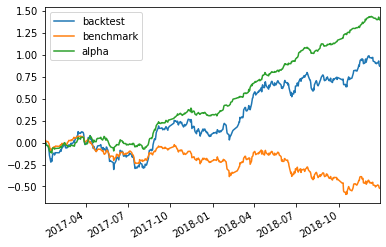

In [2933]:
#调仓周期
y_hat = DataFrame(model.predict(df_train).values.reshape(len(train_date), len(y.columns)), index=train_date, columns=y.columns)
q = 0.98
position = (y_hat.gt(y_hat.quantile(q, 1), 0)) & (y_hat.lt(y_hat.quantile(1, 1), 0))

ror_train = ror.loc[train_date, :]
r_rinei_train = r_rinei.loc[train_date, :]
r_geye_train = r_geye.loc[train_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (OPEN - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[train_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[train_date, :]).mul(len(y.columns) / position.sum(1), 0) / n

ror_huice.mean(1).cumsum().plot()

benchmark = ror_train
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300552.SZ    0.083478
300682.SZ    0.080032
002530.SZ    0.078297
000034.SZ    0.074730
002439.SZ    0.074639
300248.SZ    0.071309
300462.SZ    0.071062
300020.SZ    0.070476
000158.SZ    0.067661
300771.SZ    0.067190
Name: 2020-08-04 00:00:00, dtype: float64


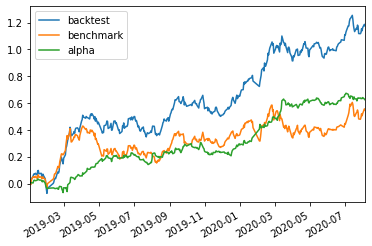

In [2934]:
#调仓周期
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
q1 = 0.98
q2 = 1
position = (y_hat.gt(y_hat.quantile(q1, 1), 0)) & (y_hat.lt(y_hat.quantile(q2, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

#ror_huice = (position * (CLOSE - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0)
ror_huice = (position * (CLOSE - OPEN).loc[test_date, :] + position.shift() * (CLOSE - CLOSE.shift()).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n
#ror_huice = (position * (CLOSE.shift(-n+1) - OPEN).loc[test_date, :]).mul(len(y.columns) / position.sum(1), 0) / n


ror_huice.mean(1).cumsum().plot()

benchmark = ror_test
benchmark.mean(1).cumsum().plot()

alpha = ror_huice.mean(1) - benchmark.mean(1)
alpha.cumsum().plot()
'''
for i in industry:
    stock = industrys[i]
    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark', 'alpha'] + [i for i in industry])
'''
plt.legend(['backtest', 'benchmark', 'alpha'])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [2936]:
position.sum(1).iloc[-1]

4

In [2842]:
alpha.mean() / alpha.std() * np.sqrt(len(ror_huice))

4.511563207813363

In [2914]:
alpha.iloc[-10:]

2020-07-22    0.004174
2020-07-23   -0.001406
2020-07-24   -0.009001
2020-07-27    0.033534
2020-07-28   -0.023779
2020-07-29    0.033787
2020-07-30    0.003475
2020-07-31    0.001030
2020-08-03   -0.019151
2020-08-04    0.048935
dtype: float64

In [2935]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].fillna(0).values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

300155.SZ    0.147633
300042.SZ    0.122856
300468.SZ    0.120252
300663.SZ    0.114992
002530.SZ    0.088467
002152.SZ    0.086053
002308.SZ    0.083794
603232.SH    0.078619
300130.SZ    0.078086
000066.SZ    0.076514
Name: 2020-08-04 00:00:00, dtype: float64


In [2916]:
print(y_hat2.iloc[-2,:].sort_values(ascending=False).dropna().iloc[:10])

300159.SZ    0.136740
002664.SZ    0.069033
002933.SZ    0.053740
600879.SH    0.052696
300810.SZ    0.052096
600391.SH    0.051708
600765.SH    0.045248
600990.SH    0.041522
600316.SH    0.041380
600343.SH    0.034479
Name: 2020-08-03 00:00:00, dtype: float64


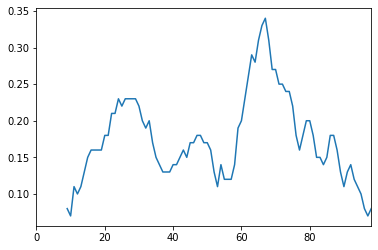

In [1935]:
Series([len(y_hat2.iloc[-i,:].sort_values(ascending=False).dropna().iloc[:10].index & y_hat2.iloc[-i-1,:].sort_values(ascending=False).dropna().iloc[:10].index)/10 for i in range(1,100)]).rolling(10).mean().plot()

In [368]:
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').